In [39]:
# Load data

import _pickle as cp
import numpy as np
import matplotlib.pyplot as plt

X, y = cp.load(open('winequality-white.pickle','rb'))

N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train

X_train_raw = X[:N_train]
y_train = y[:N_train]
X_test_raw = X[N_train:]
y_test = y[N_train:]

In [40]:
# Normalize features

def get_norms(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    return means, stds

def normalize(X, means, stds):
    return (X - means) / stds

X_means, X_stds = get_norms(X_train_raw)
X_train = normalize(X_train_raw, X_means, X_stds)
X_test = normalize(X_test_raw, X_means, X_stds)

In [41]:
# Test a mode

def mean_squared_error(predict, X, y):
    y_hat = predict(X)
    residuals = np.subtract(y, y_hat)
    squared_residuals = np.square(residuals)
    return np.mean(squared_residuals)

In [42]:
# Print summary of model

def print_summary(name, train, predict):
    train(X_train, y_train)
    mse_train = mean_squared_error(predict, X_train, y_train)
    mse_test = mean_squared_error(predict, X_test, y_test)

    print('Mean squared error of ' + name + ':')
    print('On train data ' + str(mse_train))
    print('On test data ' + str(mse_test))
    print()

In [43]:
# Plot leaning curve of model

def plot_learning_curve(train, predict, fr, to):
    mse_train_arr = np.zeros(0)
    mse_test_arr = np.zeros(0)
    n_arr = np.zeros(0)

    for i in range(20 * fr, 20 * to + 1, 20):
        X_curr = X_train[:i]
        y_curr = y_train[:i]

        train(X_curr, y_curr)
        mse_train = mean_squared_error(predict, X_curr, y_curr)
        mse_test = mean_squared_error(predict, X_test, y_test)

        n_arr = np.append(n_arr, i)
        mse_train_arr = np.append(mse_train_arr, mse_train)
        mse_test_arr = np.append(mse_test_arr, mse_test)

    plt.plot(n_arr, mse_train_arr)
    plt.plot(n_arr, mse_test_arr)
    plt.show()

In [44]:
# Trivial model

def train_trivial(X, y):
    global avg_y
    avg_y = np.average(y)

def predict_trivial(X):
    return np.repeat(avg_y, len(X))

In [45]:
# Linear regression

from numpy.linalg import inv

def transform_const(X):
    return np.insert(X, 0, 1, axis=1)

def train_lin_reg(X, y):
    global weights
    X2 = transform_const(X)
    weights = inv(X2.transpose().dot(X2)).dot(X2.transpose()).dot(y)

def predict_lin_reg(X):
    return transform_const(X).dot(weights)

In [46]:
# Polynomial basis expansion

from sklearn.preprocessing import PolynomialFeatures

def transform_poly_raw(X):
    poly = PolynomialFeatures(2)
    return poly.fit_transform(X)

def transform_poly(X):
    return normalize(transform_poly_raw(X), X_poly_means, X_poly_stds)

def get_poly_norms():
    global X_poly_means, X_poly_stds
    X_poly_train_raw = transform_poly_raw(X_train)
    X_poly_means, X_poly_stds = get_norms(X_poly_train_raw)
    X_poly_means[0] = 0
    X_poly_stds[0] = 1

get_poly_norms()

In [47]:
# Linear regression with polynomial

from numpy.linalg import inv

def train_lin_reg_poly(X, y):
    global weights
    X2 = transform_poly(X)
    weights = inv(X2.transpose().dot(X2)).dot(X2.transpose()).dot(y)

def predict_lin_reg_poly(X):
    return transform_poly(X).dot(weights)

In [48]:
# Ridge linear regression

from sklearn.linear_model import Ridge

def train_ridge(alpha, X, y):
    global clf_ridge
    clf_ridge = Ridge(alpha)
    clf_ridge.fit(transform_poly(X), y)

def predict_ridge(X):
    return clf_ridge.predict(transform_poly(X))

In [49]:
# Lasso linear regression

from sklearn.linear_model import Lasso

def train_lasso(alpha, X, y):
    global clf_lasso
    clf_lasso = Lasso(alpha)
    clf_lasso.fit(transform_poly(X), y)

def predict_lasso(X):
    return clf_lasso.predict(transform_poly(X))

In [50]:
# Fit alpha hyperparameter for a model

N_vtrain = int(0.8 * N_train)
X_vtrain = X_train[:N_vtrain]
y_vtrain = y_train[:N_vtrain]
X_valid = X_train[N_vtrain:]
y_valid = y_train[N_vtrain:]
    
def find_alpha(train, predict):
    def check_alpha(alpha):
        train(alpha, X_vtrain, y_vtrain)
        mse = mean_squared_error(predict, X_valid, y_valid)
        return mse
    
    alphas = [0.01, 0.1, 1, 10, 100]
    res = map(check_alpha, alphas)
    return alphas[np.argmin(list(res))]

In [51]:
# Find optimal alpha hyperparameters for the two models

ridge_alpha = find_alpha(train_ridge, predict_ridge)
lasso_alpha = find_alpha(train_lasso, predict_lasso)

print('Ridge alpha: ' + str(ridge_alpha))
print('Lasso alpha: ' + str(lasso_alpha))

Ridge alpha: 1
Lasso alpha: 0.01


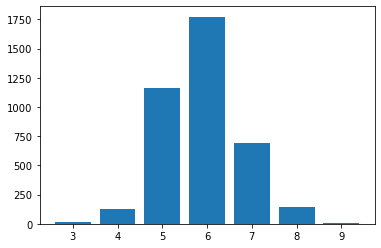

In [52]:
# Plot distribution of ys

unique, counts = np.unique(y_train, return_counts=True)

plt.bar(unique, counts)
plt.show()

In [53]:
# Print results

def apply_hyper(train, alpha):
    return (lambda X, y: train(alpha, X, y))

print_summary('trivial model', train_trivial, predict_trivial)
print_summary('linear regression', train_lin_reg, predict_lin_reg)
print_summary('ridge regression', apply_hyper(train_ridge, ridge_alpha), predict_ridge)
print_summary('lasso regression', apply_hyper(train_lasso, lasso_alpha), predict_lasso)
print_summary('linear regression w/ polynomial', train_lin_reg_poly, predict_lin_reg_poly)

Mean squared error of trivial model:
On train data 0.7767772386501117
On test data 0.8138573000045535

Mean squared error of linear regression:
On train data 0.5639996173941924
On test data 0.5607292042283468

Mean squared error of ridge regression:
On train data 0.4952284377188721
On test data 0.5125809054710266

Mean squared error of lasso regression:
On train data 0.5179330834873639
On test data 0.526764966107038

Mean squared error of linear regression w/ polynomial:
On train data 0.49522098877780635
On test data 0.5126967852427613



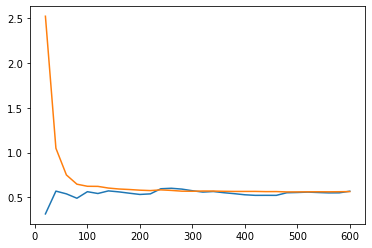

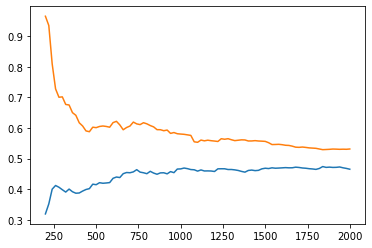

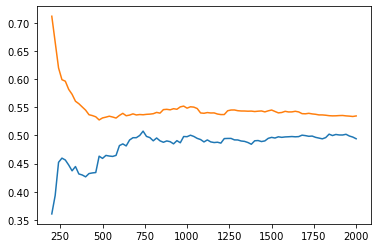

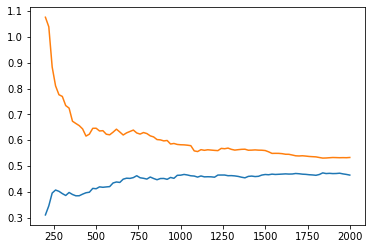

In [54]:
# Plot learning curves

plot_learning_curve(train_lin_reg, predict_lin_reg, 1 , 30)
plot_learning_curve(apply_hyper(train_ridge, ridge_alpha), predict_ridge, 10, 100)
plot_learning_curve(apply_hyper(train_lasso, lasso_alpha), predict_lasso, 10, 100)
plot_learning_curve(train_lin_reg_poly, predict_lin_reg_poly, 10, 100)